# Capstone Project - Clustering the coffee shops of London - Report

Jamie Hill - 4/5/21

<b> 1. Introduction: </b>
London is undoubtedly one of the most interesting, historic and entertaining cities in the world. It has been the capital of England for over 2000 years and is one of the world's financial and cultural hubs. Having grown up just outside of London I have long been interested in living there. Having already explored New York, my resident city, I would like to analyse London. So what do I want to analyse in London? Easy, tea and coffee. Two staples of my life but also of English people in general. The history of tea stretches all the way back to the early 17th century when the East India Company brought it over from India. Originally a drink for the rich and extravagent, it has transformed into an everyday staple for nearly every British person. Coffee has a sligthly different story and was said to be bought in from the Ottoman Empire, and coffee houses started to appear in the 17th and 18th centuries. Therefore, I will be analysing coffee shops and cafes within the London area. In order to perform this analysis I will combine various data analysis techniques including utilising APIs and clustering. 

<b> 2. Business Problem: </b>
By analysing coffee shops in London, the information can be useful for business owners looking to set up a coffee shop and/or expanding a current cafe into a new area. However, to really determine an optimal location for cafes you will need to do a multi-variate analysis looking at factors such as income per capita, tourst foot fall and rent prices. The frequency of coffee shops is one component that can influence a desision, thus  I have decided to focus on this component. The information is also useful for tourists who are looking to go for a coffee in London. It will advise them on where the highest frequency of cafes are. On a personal level, as someone who may move to London, it gives me an idea of places I may want to live.    

<b> 3. Data Description: </b>
For the London data I will use a combination of the neighborhoods listed on wikipedia: https://en.wikipedia.org/wiki/List_of_areas_of_London, the ARCGIS API to extract the latitude and longitude (geo locations) aswell as the Foursquare API to extract informmation regarding the different venues in the different locations in London. From the venue data from Foursquare we can narrow it down to just coffee shops and cafes. By combining this data into one single dataframe I am able to analyse, cluster and plot the information in an informative and presentable way. I will be using K-mean clustering algorithm, which is an unsupervised machine learning algorithm that partitions data into n number of clusters. In my analysis I decide on n=5 ie. 5 clusters.
 
<b> 4. Methodology </b>

In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from pandas.io.json import json_normalize

<b> Package breakdown: </b>
<br>Pandas : To collect and manipulate data in JSON and HTMl and then be used for data analysis
<br>Requests : Handle http requests
<br>Numpy: Helps performs mathematical functions on arrays
<br>Matplotlib : Detailing the generated maps
<br>Folium : Generating maps of London
<br>Sklearn : To import Kmeans which is the machine learning model we use
<br>GeoPy: Help collect location data

In [2]:
#Scraping the neighborhood data for London from wikipedia

url_london = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
wiki_london = requests.get(url_london)
london_data = pd.read_html(wiki_london.text)
london_data = london_data[1]
london_data

Location                     London borough       Post town  \
0         Abbey Wood              Bexley, Greenwich [7]          LONDON   
1              Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2          Addington                         Croydon[8]         CROYDON   
3         Addiscombe                         Croydon[8]         CROYDON   
4        Albany Park                             Bexley  BEXLEY, SIDCUP   
..               ...                                ...             ...   
526         Woolwich                          Greenwich          LONDON   
527   Worcester Park       Sutton, Kingston upon Thames  WORCESTER PARK   
528  Wormwood Scrubs             Hammersmith and Fulham          LONDON   
529          Yeading                         Hillingdon           HAYES   
530         Yiewsley                         Hillingdon    WEST DRAYTON   

    Postcode district Dial code OS grid ref  
0                 SE2       020    TQ465785  
1              W3, W4       020    TQ205805  
2                 CR0       020    TQ375645  
3                 CR0       020    TQ345665  
4           DA5, DA14       020    TQ478728  
..                ...       ...         ...  
526              SE18       020    TQ435795  
527               KT4       020    TQ225655  
528               W12       020    TQ225815  
529               UB4       020    TQ115825  
530               UB7       020    TQ063804  

[531 rows x 6 columns]

In [3]:
#Data preprocessing and cleaning the dataframe

#replacing spaces with underscores
london_data.rename(columns=lambda x: x.strip().replace(" ", "_"), inplace=True)

#dropping unecessary columns
london_df = london_data.drop( [ london_data.columns[0], london_data.columns[4], london_data.columns[5] ], axis=1)

#renaming columns
london_df.columns = ['borough','town','post_code']

#Stripping the number and square brackets from borough column
london_df['borough'] = london_df['borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

#Refining data to only locations in London
london_df = london_df[london_df['town'].str.contains('LONDON')]

Checking out the refined dataframe

In [4]:
print (london_df.shape)
london_df.head()

(308, 3)


borough    town post_code
0              Bexley, Greenwich   LONDON       SE2
1  Ealing, Hammersmith and Fulham  LONDON    W3, W4
6                            City  LONDON       EC3
7                     Westminster  LONDON       WC2
9                         Bromley  LONDON      SE20

I have used <b> ARCGIS </b> for longitude and latitude data to be added to the london_df.

In [5]:
from arcgis.geocoding import geocode
from arcgis.gis import GIS
gis = GIS()

In [6]:
def get_x_y_uk(address1):
   lat_coords = 0
   lng_coords = 0
   g = geocode(address='{}, London, England, GBR'.format(address1))[0]
   lng_coords = g['location']['x']
   lat_coords = g['location']['y']
   return str(lat_coords) +","+ str(lng_coords)


In [7]:
geo_coordinates_uk = london_df['post_code']    
geo_coordinates_uk

0           SE2
1        W3, W4
6           EC3
7           WC2
9          SE20
         ...   
521    IG8, E18
522         IG8
525         N12
526        SE18
528         W12
Name: post_code, Length: 308, dtype: object

In [8]:
coordinates = geo_coordinates_uk.apply(lambda x: get_x_y_uk(x))
coordinates

0       51.492450000000076,0.12127000000003818
1        51.51324000000005,-0.2674599999999714
6       51.51200000000006,-0.08057999999994081
7       51.51651000000004,-0.11967999999995982
9       51.41009000000008,-0.05682999999993399
                        ...                   
521    51.589770000000044,0.030520000000024083
522      51.50642000000005,-0.1272099999999341
525     51.615920000000074,-0.1767399999999384
526      51.48207000000008,0.07143000000002075
528      51.50645000000003,-0.2369099999999662
Name: post_code, Length: 308, dtype: object

In [9]:
lat_uk = coordinates.apply(lambda x: x.split(',')[0])
lat_uk

0      51.492450000000076
1       51.51324000000005
6       51.51200000000006
7       51.51651000000004
9       51.41009000000008
              ...        
521    51.589770000000044
522     51.50642000000005
525    51.615920000000074
526     51.48207000000008
528     51.50645000000003
Name: post_code, Length: 308, dtype: object

In [10]:
lng_uk = coordinates.apply(lambda x: x.split(',')[1])
lng_uk

0       0.12127000000003818
1       -0.2674599999999714
6      -0.08057999999994081
7      -0.11967999999995982
9      -0.05682999999993399
               ...         
521    0.030520000000024083
522     -0.1272099999999341
525     -0.1767399999999384
526     0.07143000000002075
528     -0.2369099999999662
Name: post_code, Length: 308, dtype: object

Now we have the longitudes and latitudes we need to concatenate them to the london_df.

In [11]:
london_merged = pd.concat([london_df,lat_uk.astype(float), lng_uk.astype(float)], axis=1)
london_merged.columns= ['borough','town','post_code','latitude','longitude']
london_merged
#n19_london = london_merged[london_merged['post_code'].str.contains('N19')]
#n19_london

borough                    town post_code  \
0                Bexley, Greenwich                   LONDON       SE2   
1    Ealing, Hammersmith and Fulham                  LONDON    W3, W4   
6                              City                  LONDON       EC3   
7                       Westminster                  LONDON       WC2   
9                           Bromley                  LONDON      SE20   
..                              ...                     ...       ...   
521                       Redbridge                  LONDON  IG8, E18   
522       Redbridge, Waltham Forest  LONDON, WOODFORD GREEN       IG8   
525                          Barnet                  LONDON       N12   
526                       Greenwich                  LONDON      SE18   
528          Hammersmith and Fulham                  LONDON       W12   

     latitude  longitude  
0    51.49245    0.12127  
1    51.51324   -0.26746  
6    51.51200   -0.08058  
7    51.51651   -0.11968  
9    51.41009   -0.05683  
..        ...        ...  
521  51.58977    0.03052  
522  51.50642   -0.12721  
525  51.61592   -0.17674  
526  51.48207    0.07143  
528  51.50645   -0.23691  

[308 rows x 5 columns]

In [12]:
#Getting the geocode of london

london = geocode(address='London, England, GBR')[0]
long = london['location']['x']
lat = london['location']['y']
print (long, lat)

-0.1272099999999341 51.50642000000005


Now we want to map all of the London Neighbourhoods

In [13]:
# Creating the map of London
map_London = folium.Map(location=[lat, long], zoom_start=12)
map_London

# adding markers to map
for latitude, longitude, borough, town in zip(london_merged['latitude'], london_merged['longitude'], london_merged['borough'], london_merged['town']):
    label = '{}, {}'.format(town, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='red',
        fill=True
        ).add_to(map_London)  
    
map_London


Now that we have the Neighborhoods of London in a map format, the next thing to do is use the <b> Foursquare API </b> to pull venue data. From the venue data we will be able to narrow down to just the coffee shops and cafes.

In [14]:
CLIENT_ID = 'LJRIOPWXRMA5UQFWDFWIBDVT3LVFX2V3HIZAYGTHRQRN2O2H'
CLIENT_SECRET = 'WEJBTAHLZOOPSXTAKADWTTD4D12DSFI0U2NKE2DCOTKFNEW1'
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('Foursquare_ID: ' + CLIENT_ID)
print('Foursquare_Secret:' + CLIENT_SECRET)

Your credentials:
Foursquare_ID: LJRIOPWXRMA5UQFWDFWIBDVT3LVFX2V3HIZAYGTHRQRN2O2H
Foursquare_Secret:WEJBTAHLZOOPSXTAKADWTTD4D12DSFI0U2NKE2DCOTKFNEW1


Using Foursquare we can extract information about each neighbourhood including the venue, the category and their geo-coordinates. Below we create a function that does exactly that.

In [15]:
LIMIT=100

def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            LIMIT
            )

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Category']

    return(nearby_venues)

And now we want to extract the venues:

In [16]:
ldn_venues = getNearbyVenues(london_merged['borough'], london_merged['latitude'], london_merged['longitude'])

Bexley, Greenwich 
Ealing, Hammersmith and Fulham
City
Westminster
Bromley
Islington
Islington
Barnet
Enfield
Wandsworth
Southwark
City
Richmond upon Thames
Barnet
Islington
Wandsworth
Westminster
Bromley
Newham
Ealing
Westminster
Lewisham
Camden
Southwark
Tower Hamlets
Bexley
City
Lewisham
Greenwich
Tower Hamlets
Camden
Haringey
Tower Hamlets
Haringey
Barnet
Brent
Lambeth
Lewisham
Tower Hamlets
Kensington and Chelsea, Hammersmith and Fulham
Brent
Barnet
Barnet
Southwark
Tower Hamlets
Camden
Tower Hamlets
Waltham Forest
Newham
Islington
Richmond upon Thames
Lewisham
Camden
Westminster
Greenwich
Kensington and Chelsea
Barnet
Westminster
Lewisham
Waltham Forest
Hounslow, Ealing, Hammersmith and Fulham
Brent
Barnet
Lambeth, Wandsworth
Islington
Barnet
Merton
Barnet
Westminster
Barnet, Brent, Camden
Lewisham
Bexley
Haringey
Bromley
Tower Hamlets
Newham
Hackney
Islington
Southwark
Lewisham
Brent
Southwark
Ealing
Kensington and Chelsea
Wandsworth
Southwark
Barnet
Newham
Richmond upon Thames


In [17]:
#Resulting data looks like this
ldn_venues.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Bexley, Greenwich                 51.49245                  0.12127   
1  Bexley, Greenwich                 51.49245                  0.12127   
2  Bexley, Greenwich                 51.49245                  0.12127   
3  Bexley, Greenwich                 51.49245                  0.12127   
4  Bexley, Greenwich                 51.49245                  0.12127   

                              Venue Venue Category  
0                      Lesnes Abbey  Historic Site  
1                       Sainsbury's    Supermarket  
2                              Lidl    Supermarket  
3  Abbey Wood Railway Station (ABW)  Train Station  
4                       Bean @ Work    Coffee Shop

In [18]:
#looking at the most popular venue categories
ldn_venues2 = ldn_venues['Venue Category'].value_counts()
ldn_venues2.head(20)

Pub                     783
Coffee Shop             683
Café                    580
Italian Restaurant      315
Hotel                   311
Grocery Store           297
Park                    227
Bakery                  225
Sandwich Place          211
Pizza Place             207
Gym / Fitness Center    198
Supermarket             169
Indian Restaurant       164
Bar                     154
Fast Food Restaurant    138
Restaurant              137
Burger Joint            129
Pharmacy                128
Bus Stop                125
Clothing Store          116
Name: Venue Category, dtype: int64

Interestingly, but not suprisingly, the most frequent venue in London is the pub. Following the pub is coffee shops and cafes. In my analysis I have combined these two. Although this list gives a good idea of the most popular venues it should be taken with a grain of salt as alot of the categories would be grouped together in a perfect world ie. Indian restaurants and Fast food restaurants. 

In [19]:
#Narrowing down the venues to just coffee shops and cafes
all_ldn_coffee = ldn_venues[ldn_venues['Venue Category'].isin(["Café", "Coffee Shop"])]
all_ldn_coffee.count()

Neighbourhood              1263
Neighbourhood Latitude     1263
Neighbourhood Longitude    1263
Venue                      1263
Venue Category             1263
dtype: int64

In [20]:
all_ldn_coffee['Neighbourhood'].value_counts()

Westminster                                       187
Camden                                            110
Islington                                          92
Barnet                                             92
Hackney                                            82
Southwark                                          59
Hammersmith and Fulham                             55
Lewisham                                           54
Tower Hamlets                                      52
Haringey                                           50
Kensington and Chelsea                             46
Newham                                             42
Wandsworth                                         40
Lambeth                                            40
Waltham Forest                                     35
Merton                                             26
City                                               17
Croydon                                            16
Enfield                     

<AxesSubplot:>

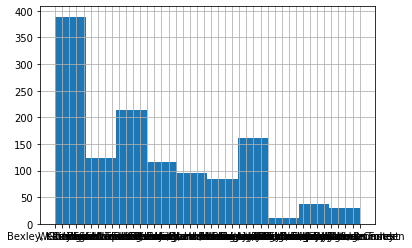

Another interesting observation here is that Westminster has the highest number of coffee shops/cafes in London. In a deeper analysis I would find the highest number of coffee shops per capita but for the moment this is an interesting observation. 

In [21]:
#Our new dataframe containing coffee shops
all_ldn_coffee.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
4   Bexley, Greenwich                 51.49245                  0.12127   
12                City                51.51200                 -0.08058   
13                City                51.51200                 -0.08058   
28                City                51.51200                 -0.08058   
51                City                51.51200                 -0.08058   

                     Venue Venue Category  
4              Bean @ Work    Coffee Shop  
12         The Association    Coffee Shop  
13  Curators Coffee Studio    Coffee Shop  
28      Black Sheep Coffee    Coffee Shop  
51                canteenM           Café

I now have the number of coffee shops by neighbourhood. I now want to put that on a map before I use K-means clustering.

In [22]:
coffee_map = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, name, categories, address in zip(all_ldn_coffee['Neighbourhood Latitude'], all_ldn_coffee['Neighbourhood Longitude'], 
                                           all_ldn_coffee['Venue'], all_ldn_coffee['Venue Category'],\
                                               all_ldn_coffee['Neighbourhood']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(coffee_map)  
    
coffee_map

The above map does not give alot of information, and not all of the coffee shops in my dataframe. Now I want to use K-means clustering to cluster the areas with the most coffee shops into 5 different areas.

In [23]:
# set number of clusters
k_num_clusters = 5

London_grouped_clustering = all_ldn_coffee.drop(['Neighbourhood', 'Venue', 'Venue Category'], 1)

# run k-means clustering
kmeans_london = KMeans(n_clusters=k_num_clusters, random_state=0).fit(London_grouped_clustering)
kmeans_london

KMeans(n_clusters=5, random_state=0)

In [24]:
#labelling London 
kmeans_london.labels_

array([3, 1, 1, ..., 2, 4, 4])

In [25]:
#Inserting a cluster label column into df
all_ldn_coffee.insert(0, 'Cluster Labels', kmeans_london.labels_ +1)

In [26]:
#seeing new df with new column
all_ldn_coffee.head()

Cluster Labels       Neighbourhood  Neighbourhood Latitude  \
4                4  Bexley, Greenwich                 51.49245   
12               2                City                51.51200   
13               2                City                51.51200   
28               2                City                51.51200   
51               2                City                51.51200   

    Neighbourhood Longitude                   Venue Venue Category  
4                   0.12127             Bean @ Work    Coffee Shop  
12                 -0.08058         The Association    Coffee Shop  
13                 -0.08058  Curators Coffee Studio    Coffee Shop  
28                 -0.08058      Black Sheep Coffee    Coffee Shop  
51                 -0.08058                canteenM           Café

In [27]:
ldn_data_nonan = all_ldn_coffee.dropna(subset=['Cluster Labels'])
#ldn_data_nonan = ldn_data_nonan.drop_duplicates()

In [28]:
ldn_data_nonan.head()

Cluster Labels       Neighbourhood  Neighbourhood Latitude  \
4                4  Bexley, Greenwich                 51.49245   
12               2                City                51.51200   
13               2                City                51.51200   
28               2                City                51.51200   
51               2                City                51.51200   

    Neighbourhood Longitude                   Venue Venue Category  
4                   0.12127             Bean @ Work    Coffee Shop  
12                 -0.08058         The Association    Coffee Shop  
13                 -0.08058  Curators Coffee Studio    Coffee Shop  
28                 -0.08058      Black Sheep Coffee    Coffee Shop  
51                 -0.08058                canteenM           Café

In [29]:
ldn_data_nonan['Neighbourhood'].value_counts()

Westminster                                       187
Camden                                            110
Islington                                          92
Barnet                                             92
Hackney                                            82
Southwark                                          59
Hammersmith and Fulham                             55
Lewisham                                           54
Tower Hamlets                                      52
Haringey                                           50
Kensington and Chelsea                             46
Newham                                             42
Wandsworth                                         40
Lambeth                                            40
Waltham Forest                                     35
Merton                                             26
City                                               17
Croydon                                            16
Enfield                     

Now we are plotting the clusters that have been created.

In [30]:
ldn_map = folium.Map(location=[lat, long], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k_num_clusters)
ys = [i + x + (i*x)**2 for i in range(k_num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ldn_data_nonan['Neighbourhood Latitude'], ldn_data_nonan['Neighbourhood Longitude'], ldn_data_nonan['Neighbourhood'], ldn_data_nonan['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) +1) + '\n' + str(poi) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)]
        ).add_to(ldn_map)
        
ldn_map

It looks good. Now we need to analyse them. 

In [31]:
#Cluster 1
ldn_data_nonan.loc[ldn_data_nonan['Cluster Labels'] == 1, ldn_data_nonan.columns[[1] + list(range(5, ldn_data_nonan.shape[1]))]]

Neighbourhood Venue Category
987    Tower Hamlets           Café
989    Tower Hamlets           Café
990    Tower Hamlets    Coffee Shop
991    Tower Hamlets           Café
992    Tower Hamlets    Coffee Shop
...              ...            ...
9832          Newham    Coffee Shop
9833          Newham    Coffee Shop
9848          Newham    Coffee Shop
10122  Tower Hamlets    Coffee Shop
10202      Redbridge    Coffee Shop

[178 rows x 2 columns]

In [32]:
#Cluster 2
ldn_data_nonan.loc[ldn_data_nonan['Cluster Labels'] == 2, ldn_data_nonan.columns[[1] + list(range(5, ldn_data_nonan.shape[1]))]]

Neighbourhood Venue Category
12                          City    Coffee Shop
13                          City    Coffee Shop
28                          City    Coffee Shop
51                          City           Café
82                          City    Coffee Shop
...                          ...            ...
10029                Westminster    Coffee Shop
10040                Westminster           Café
10051                Westminster    Coffee Shop
10055                Westminster           Café
10254  Redbridge, Waltham Forest           Café

[438 rows x 2 columns]

In [33]:
#Cluster 3
ldn_data_nonan.loc[ldn_data_nonan['Cluster Labels'] == 3, ldn_data_nonan.columns[[1] + list(range(5, ldn_data_nonan.shape[1]))]]

Neighbourhood Venue Category
274       Islington           Café
277       Islington    Coffee Shop
282       Islington    Coffee Shop
284       Islington    Coffee Shop
289       Islington    Coffee Shop
...             ...            ...
10283        Barnet    Coffee Shop
10286        Barnet    Coffee Shop
10288        Barnet    Coffee Shop
10300        Barnet    Coffee Shop
10303        Barnet           Café

[237 rows x 2 columns]

In [34]:
#Cluster 4
ldn_data_nonan.loc[ldn_data_nonan['Cluster Labels'] == 4, ldn_data_nonan.columns[[1] + list(range(5, ldn_data_nonan.shape[1]))]]

Neighbourhood Venue Category
4     Bexley, Greenwich     Coffee Shop
725               Newham           Café
734               Newham           Café
735               Newham           Café
741               Newham           Café
...                  ...            ...
9394             Croydon           Café
9451              Newham           Café
9454              Newham           Café
9457              Newham           Café
9897              Bexley    Coffee Shop

[143 rows x 2 columns]

In [35]:
#Cluster 5
ldn_data_nonan.loc[ldn_data_nonan['Cluster Labels'] == 5, ldn_data_nonan.columns[[1] + list(range(5, ldn_data_nonan.shape[1]))]]

Neighbourhood Venue Category
350                Wandsworth    Coffee Shop
352                Wandsworth    Coffee Shop
360                Wandsworth    Coffee Shop
374                Wandsworth           Café
375                Wandsworth    Coffee Shop
...                       ...            ...
10156                  Merton           Café
10161                  Merton    Coffee Shop
10165                  Merton    Coffee Shop
10314  Hammersmith and Fulham           Café
10323  Hammersmith and Fulham           Café

[267 rows x 2 columns]

<b>Results and Discussion <b/>

There are lots of options in London to get a good coffee. But if you are looking for places with the highest frequency of coffee shops you want to visit Westminster and central london cluster 5, where there are 439 coffee shops. After that the area with the most coffee shops is cluster 1 which is west London, Wandsworth, Chelsea area. Areas you want to avoid include Kingston and Redbridge where the number of coffee shops are lower than other boroughs. These are in cluster 3 and are around south to south-east London. The frequency of coffee shops being lower than central makes sense as they are further away from tourist hotspots, hence less of an incentive for a potential owner to set up a coffee shop. My findings are in line with common sense that the highest number of coffee shops are in the center of London where tourism is highest and where per capita incomes are high. 
<br> Tourists were not our only stakeholders. In terms of owners looking to set up a coffee shop, based on simply frequency of coffee shops, the argument can be made for setting up in the area with the least coffee shops, but also with the most. Cluster 3 had the least coffee shops, this could be seen as a potential business opportunity if there is a gap in the market. However there may be a reason for the lower frequency of coffeee shops there, for example low tourist footfall. Owners often look for places with high tourist footfall, hence why central london, cluster 5, has the highest frequency. But by setting up a shop in central london you have to consider other variables; the competition and the rent prices, both pivotal decisions.
    
<b> Discussion </b>
    
In hindsight, there are many more variables that need to be examined when both looking at getting a coffee and also setting up a coffee shop. When looking to purchase, the quality of coffee, the quality of the area and the price are all important factors. When looking to sell, the per capita income, tourist footfall and the rent prices are crucial pieces to the decision. Both of the stakeholders would want to run a multi-variate analysis. However, the frequency of coffee shops is one part of the puzzle. 


<b> Conclusion </b>

The purpose of this projct was to examine clusters of coffee shops in London. We did that using geolocations from ArcGIS and venue information from the Foursquare API. We extracted the areas with the most and least coffee shops. Overall it was a good project to put my python skills to use, utilise APIs and to explore a city where I may live in the future. In conclusion, if you are looking to find a coffee without going very far - go to Central London, if you are looking to set up a coffee shop - pay someone to do a in depth multi-variate analysis. 